In [61]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    HardPhongShader,
    TexturesVertex,
)
from pytorch3d.transforms import Rotate, euler_angles_to_matrix
from pytorch3d.io import save_obj

class GridCubeEnv:
    def __init__(self, grid_size=8):
        self.grid_size = grid_size
        self.grid = torch.ones((grid_size, grid_size, grid_size), dtype=torch.float32)
        self.agent_position = torch.randint(0, grid_size, (3,), dtype=torch.int32)

    def reset(self):
        self.grid = torch.ones((self.grid_size, self.grid_size, self.grid_size), dtype=torch.float32)
        self.agent_position = torch.tensor([0, 0, 0])#torch.randint(0, self.grid_size, (3,), dtype=torch.int32)
        self.grid[tuple(self.agent_position)] = 0
        return self.grid.clone(), self.agent_position.clone()

    def step(self, action):
        movement = torch.tensor([
            [1, 0, 0],   # forward
            [-1, 0, 0],  # back
            [0, 1, 0],   # right
            [0, -1, 0],  # left
            [0, 0, 1],   # up
            [0, 0, -1]   # down
        ], dtype=torch.int32)

        new_position = self.agent_position + movement[action]

        if torch.all(new_position >= 0) and torch.all(new_position < self.grid_size):
            self.agent_position = new_position

        self.grid[tuple(self.agent_position)] = 0

        reward = 1.0
        done = torch.all(self.grid == 0).item()

        return self.grid.clone(), self.agent_position.clone(), reward, done

    def render(self, save_path="rendered_scene.png"):
        # Create vertices for each cube cell in the grid
        vertices = []
        faces = []
        colors = []
        vert_offset = 0

        # For each cell in the grid
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                for z in range(self.grid_size):
                    # If the cell is 1 (not visited), create a cube
                    if self.grid[x, y, z] == 1:
                        v, f = self.create_cube(x, y, z)
                        vertices.append(v)
                        faces.append(f + vert_offset)  # Correctly offset faces by the current vertex offset
                        colors.append(torch.tensor([[0.8, 0.8, 0.8]] * 8))  # Light grey for unvisited cells
                        vert_offset += v.shape[0]  # Update the vertex offset

        # Create a different color for the agent
        v, f = self.create_cube(*self.agent_position)
        vertices.append(v)
        faces.append(f + vert_offset)  # Correctly offset faces by the current vertex offset
        colors.append(torch.tensor([[1.0, 0.0, 0.0]] * 8))  # Red for the agent

        # Concatenate all vertices, faces, and colors
        vertices = torch.cat(vertices)
        faces = torch.cat(faces)
        colors = torch.cat(colors).unsqueeze(0)  # Shape to (1, V, 3)

        # Create mesh with vertex colors
        textures = TexturesVertex(verts_features=colors)
        mesh = Meshes(verts=[vertices], faces=[faces], textures=textures)

        # Set up the renderer
        cameras = FoVPerspectiveCameras(device="cpu")
        raster_settings = RasterizationSettings(
            image_size=512,
            blur_radius=0.0,
            faces_per_pixel=1,
        )
        lights = PointLights(device="cpu", location=[[2.0, 2.0, -2.0]])

        renderer = MeshRenderer(
            rasterizer=MeshRasterizer(
                cameras=cameras,
                raster_settings=raster_settings
            ),
            shader=HardPhongShader(
                device="cpu",
                cameras=cameras,
                lights=lights
            )
        )

        # Set the camera to view the entire grid
        R, T = look_at_view_transform(dist=10, elev=210, azim=90)
        roll_angle_degrees = 90
        roll_angle_radians = torch.tensor(roll_angle_degrees * torch.pi / 180)

        # Step 3: Create the roll rotation matrix around the Z-axis (camera's view axis)
        roll_matrix = euler_angles_to_matrix(torch.tensor([0, 0, roll_angle_radians]), "XYZ")

        # Step 4: Apply the roll rotation to the camera rotation matrix
        R = torch.matmul(R, roll_matrix)
        image = renderer(mesh, R=R, T=T)
        plt.figure(figsize=(10, 10))
        plt.imshow(image[0, ..., :3].cpu().numpy())
        plt.axis("off")
        plt.show()


    def create_cube(self, x, y, z):
        # Create a unit cube centered at (x, y, z)
        vertices = torch.tensor([
            [-0.5, -0.5, -0.5],
            [0.5, -0.5, -0.5],
            [0.5, 0.5, -0.5],
            [-0.5, 0.5, -0.5],
            [-0.5, -0.5, 0.5],
            [0.5, -0.5, 0.5],
            [0.5, 0.5, 0.5],
            [-0.5, 0.5, 0.5]
        ]) + torch.tensor([x, y, z])

        faces = torch.tensor([
            [0, 1, 2], [0, 2, 3],  # back face
            [4, 5, 6], [4, 6, 7],  # front face
            [0, 1, 5], [0, 5, 4],  # bottom face
            [2, 3, 7], [2, 7, 6],  # top face
            [0, 3, 7], [0, 7, 4],  # left face
            [1, 2, 6], [1, 6, 5],  # right face
        ])

        return vertices, faces

# Example usage



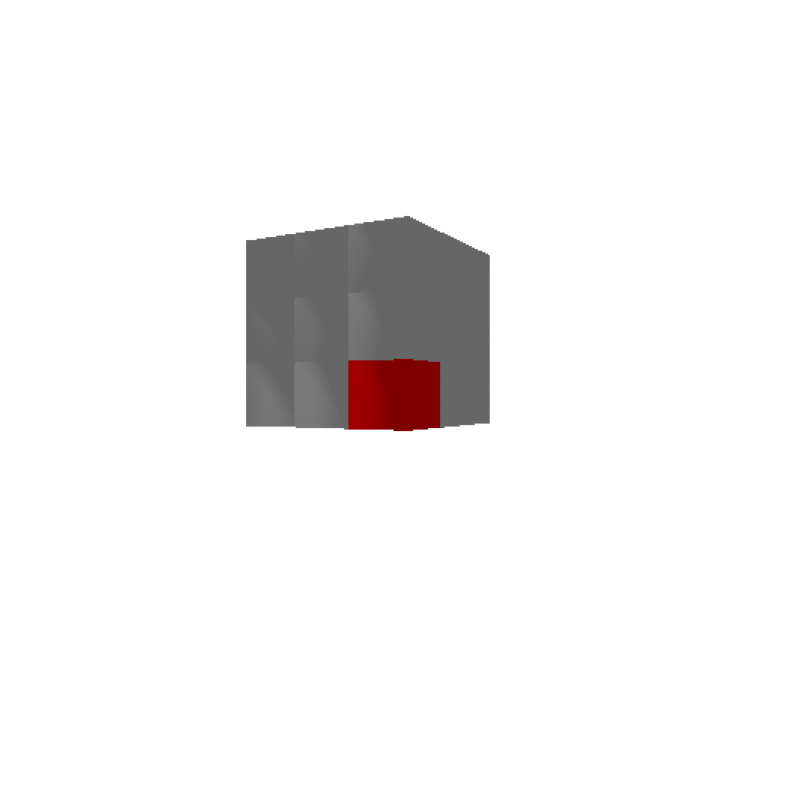

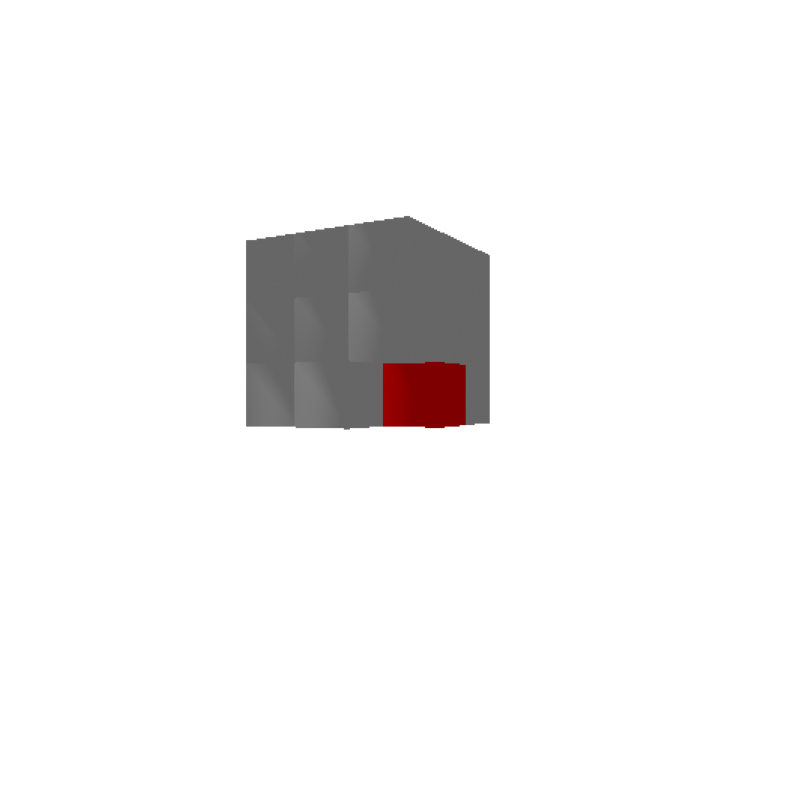

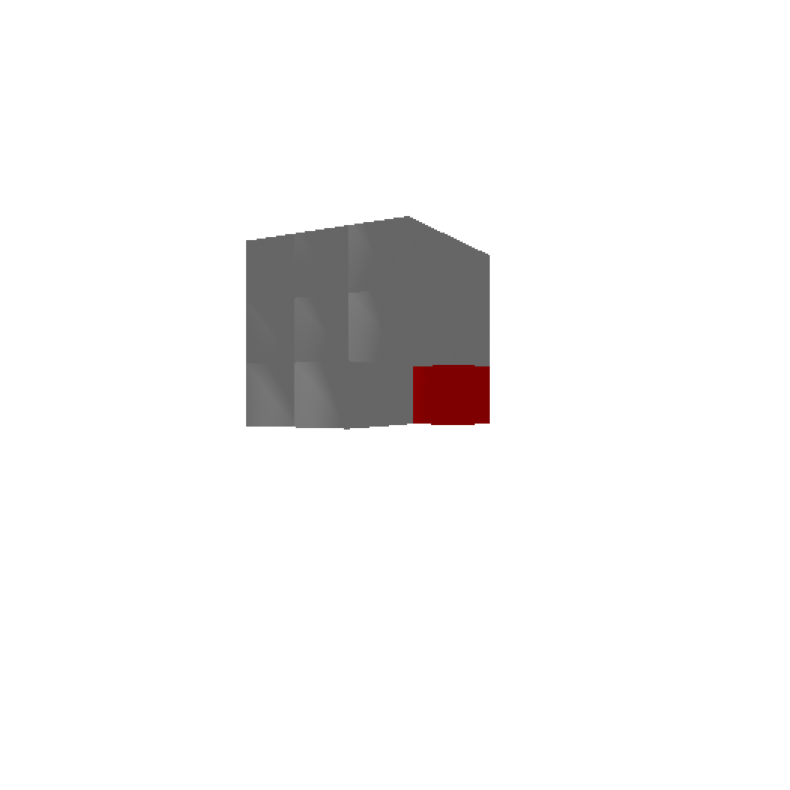

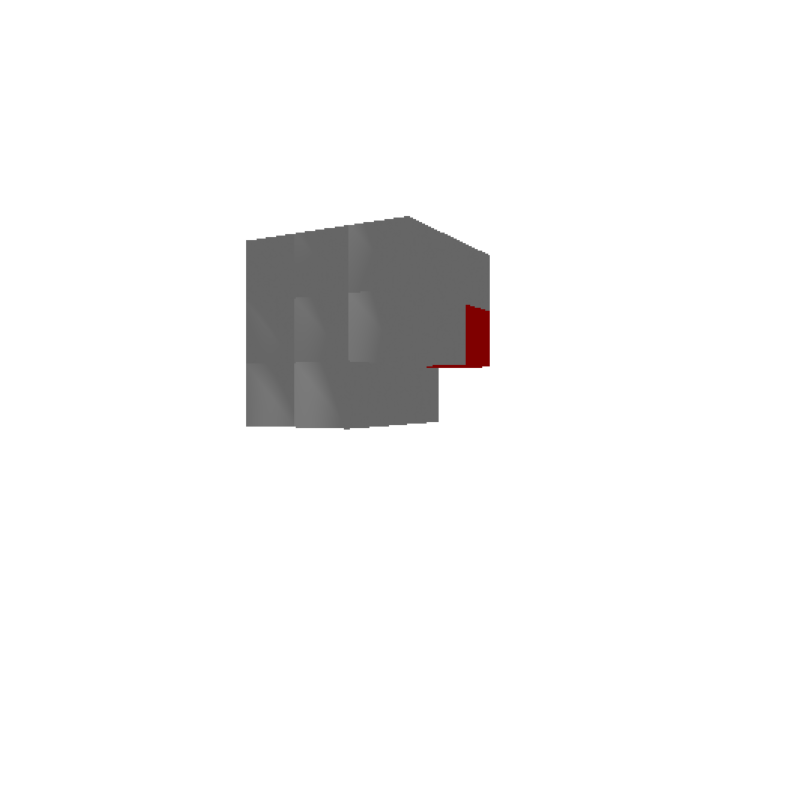

Finished in 3 steps.


In [62]:
env = GridCubeEnv(grid_size=3)
state, agent_position = env.reset()
env.render()

done = False
step_count = 0
actions = [0,0,4] # forward, forward, up
for action in actions:
    if not done:
        # action = torch.randint(0, 6, (1,)).item()  # Random action
        state, agent_position, reward, done = env.step(action)
        env.render()
        step_count += 1

print(f"Finished in {step_count} steps.")
